# Hyper Parameter Optimization For GradientBoostingRegression

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'GBR'

In [2]:
current_path = os.getcwd()
current_path

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/qiujiangwen441/code/Users/qiujiangwen44/Band-gap-predict/SingleModels/GBR'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.draw import plot_feature_importance, plot_feature_importance
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [6]:
# using random search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimization begin...")
# define the parameter distributions  for the KNN model
param_distributions = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 7, 10],
    'max_features': ['sqrt', 'log2', 0.25, 0.5, 1],
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED)
# create a randomized search CV object
# using n_iter=50 for a faster search, you can increase this for better results(n_iter=5, runtime=4min)
# forget to assign metrics score, the default is R2 score
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_distributions,
                n_iter=200, cv=kf, verbose=2, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(dft_train_X, dft_train_y)


['DFT GBR'] HP optimization begin...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, n_estimators=500; total time=  28.8s
[CV] END learning_rate=0.01, max_depth=3, max_features=0.5, n_estimators=200; total time=  56.7s
[CV] END learning_rate=0.2, max_depth=3, max_features=0.25, n_estimators=500; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=5, max_features=log2, n_estimators=300; total time=  18.5s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, n_estimators=500; total time=  18.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=1, n_estimators=200; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=1, n_estimators=200; total time=   4.8s
[CV] END learning_rate=0.1, max_depth=10, max_features=0.25, n_estimators=500; total time= 3.9min
[CV] END learning_rate=0.2, max_depth=4, max_features=0.5, n_estimators=200; total time= 1.3min
[CV] END learning_rate=0.2, m

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 7, 10],
                                        'max_features': ['sqrt', 'log2', 0.25,
                                                         0.5, 1],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [8]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_n_estimators', 'param_max_depth', 
                                 'param_learning_rate', 'param_max_features', 'train_rmse', 'test_rmse']]
# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'dft_random_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'n_estimators': 500, 'max_features': 0.25, 'max_depth': 10, 'learning_rate': 0.05}
Best Cross-Validation RMSE: 0.7001


,rank_test_score,param_n_estimators,param_max_depth,param_learning_rate,param_max_features,train_rmse,test_rmse
141,1,500,10,0.05,0.25,0.274987,0.700081
116,2,500,10,0.05,0.5,0.278916,0.701481
130,3,500,10,0.05,sqrt,0.279913,0.704113
165,4,300,10,0.05,0.25,0.342834,0.706628
12,5,500,10,0.10,0.25,0.218659,0.707899


### Overfitting check

####################################################################################################
[DFT - GBR] Training GBR on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total= 3.3min
Model training completed!
[Train_error] Evaluating DFT GBR on DFT train set:


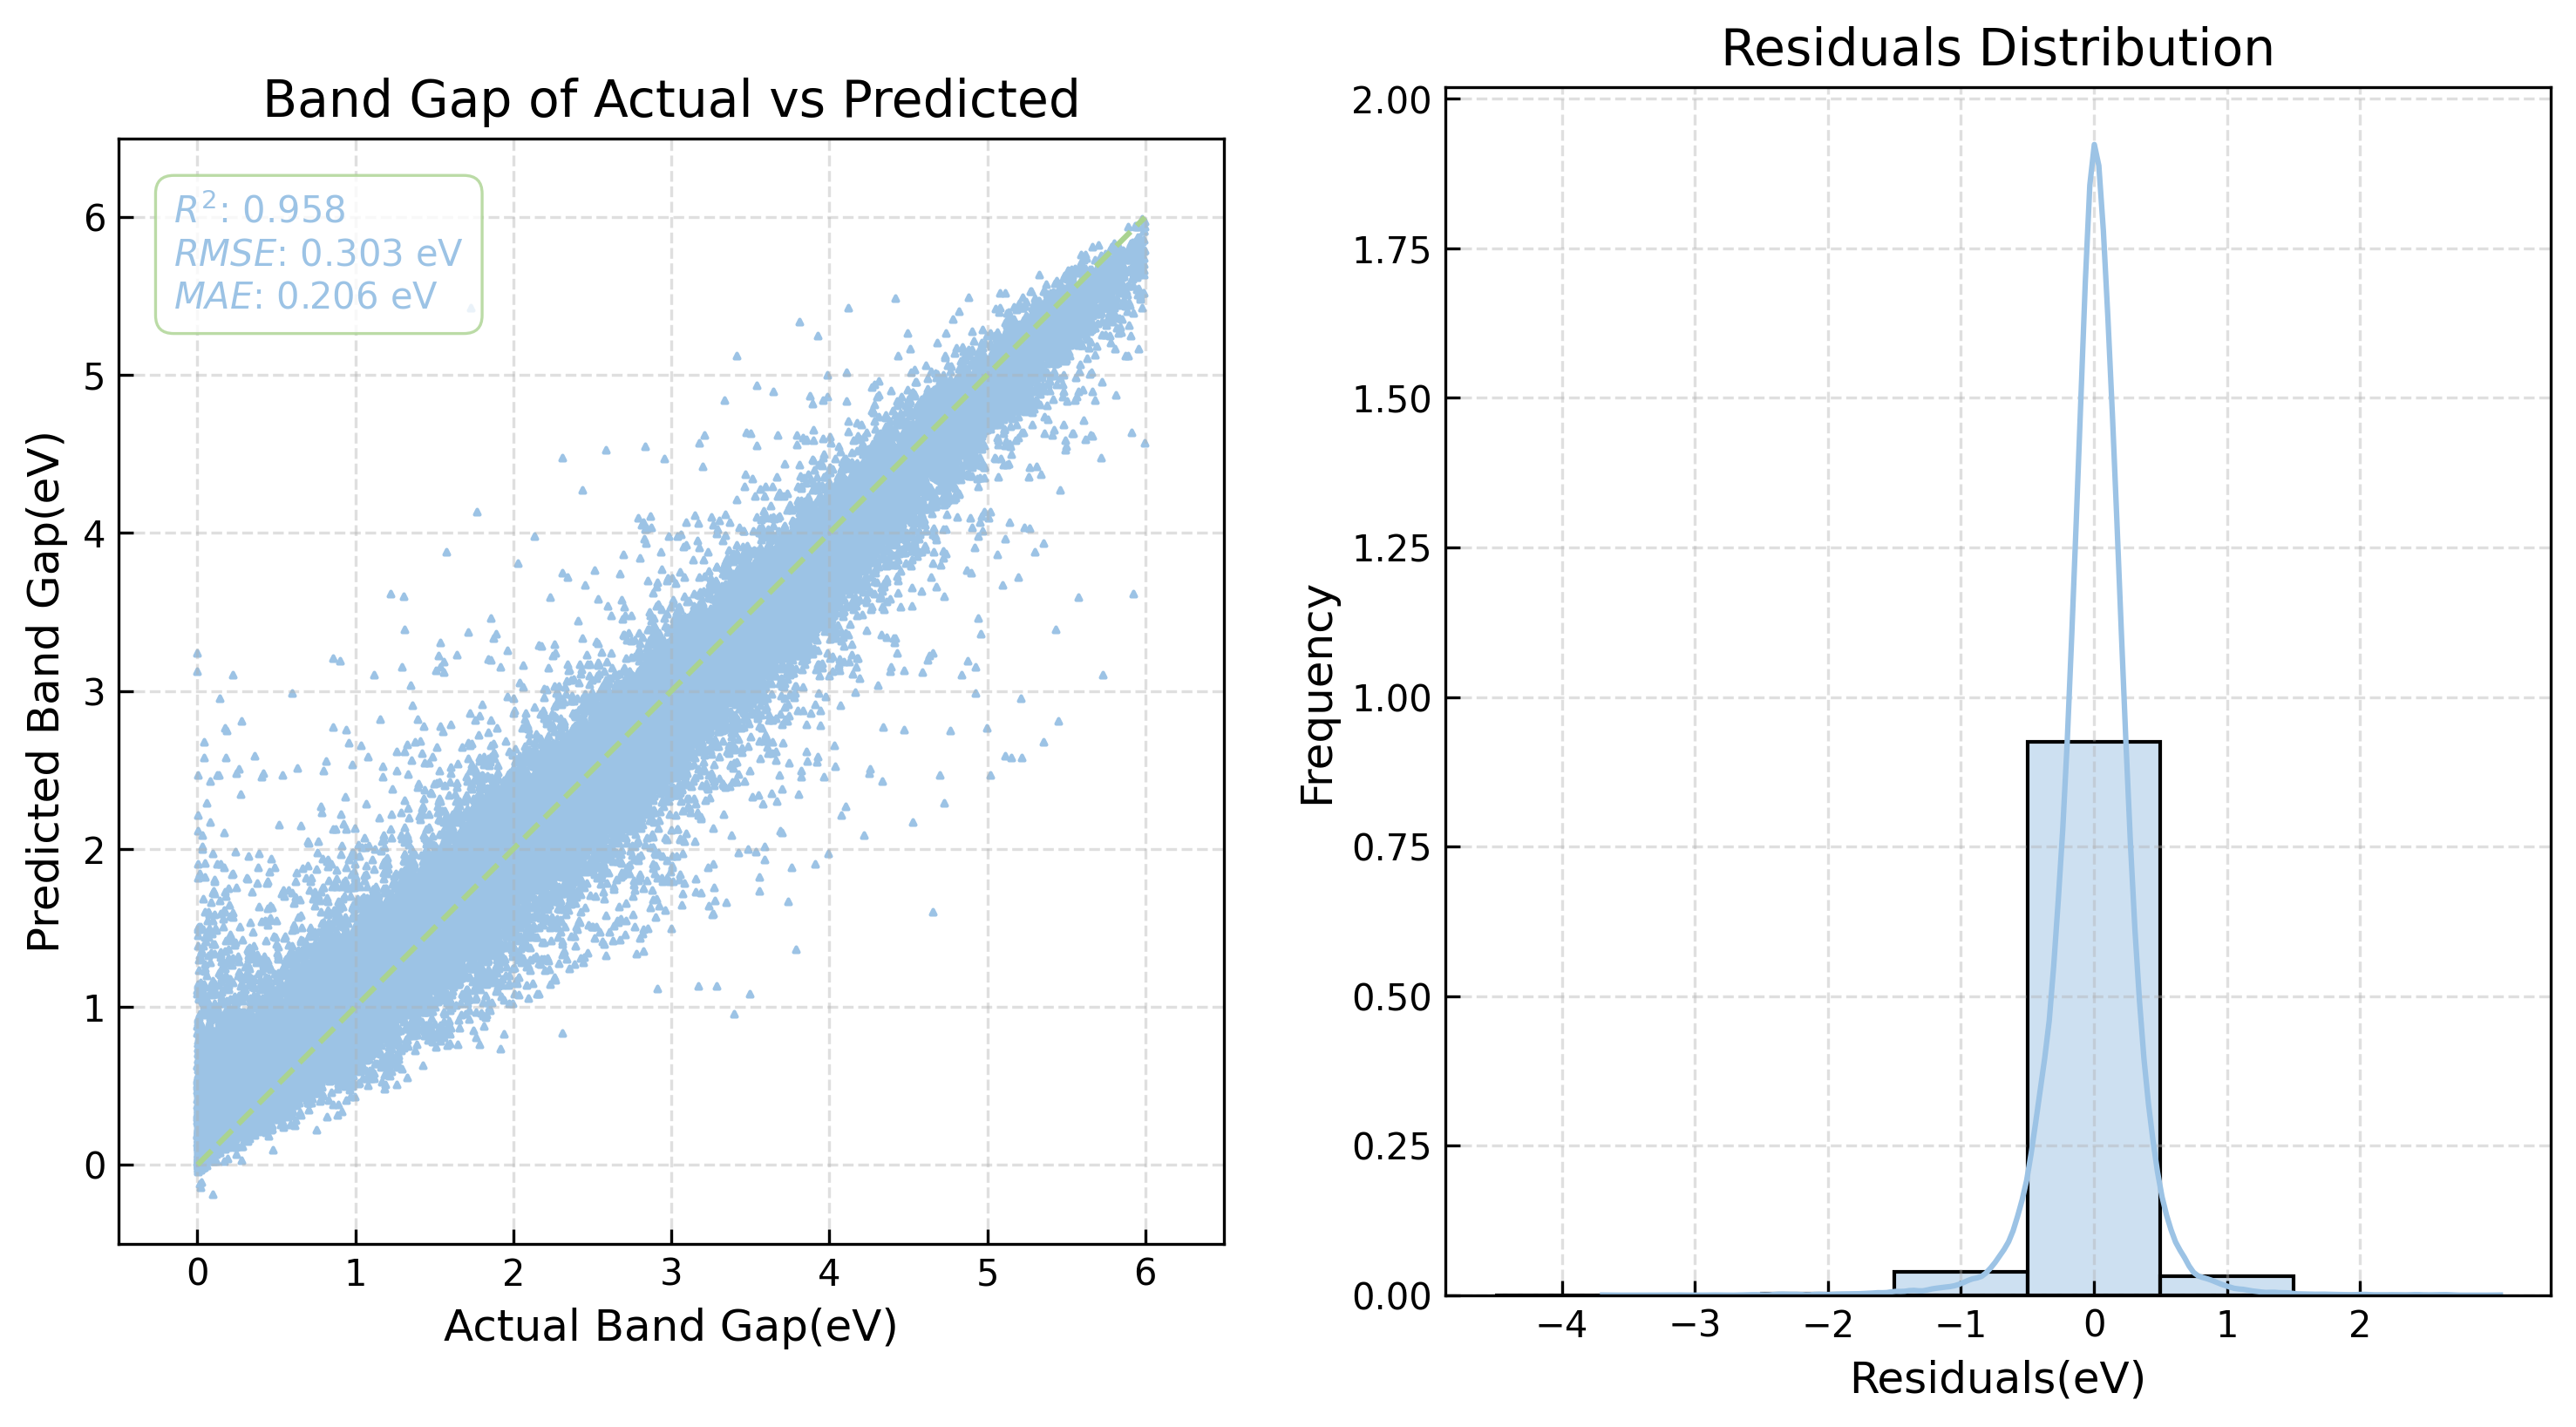


Model Evaluation Results:
Test set: R²: 0.9580 RMSE: 0.3027 MAE: 0.2064
[Test DFT -> DFT] Evaluating DFT GBR on DFT test set:


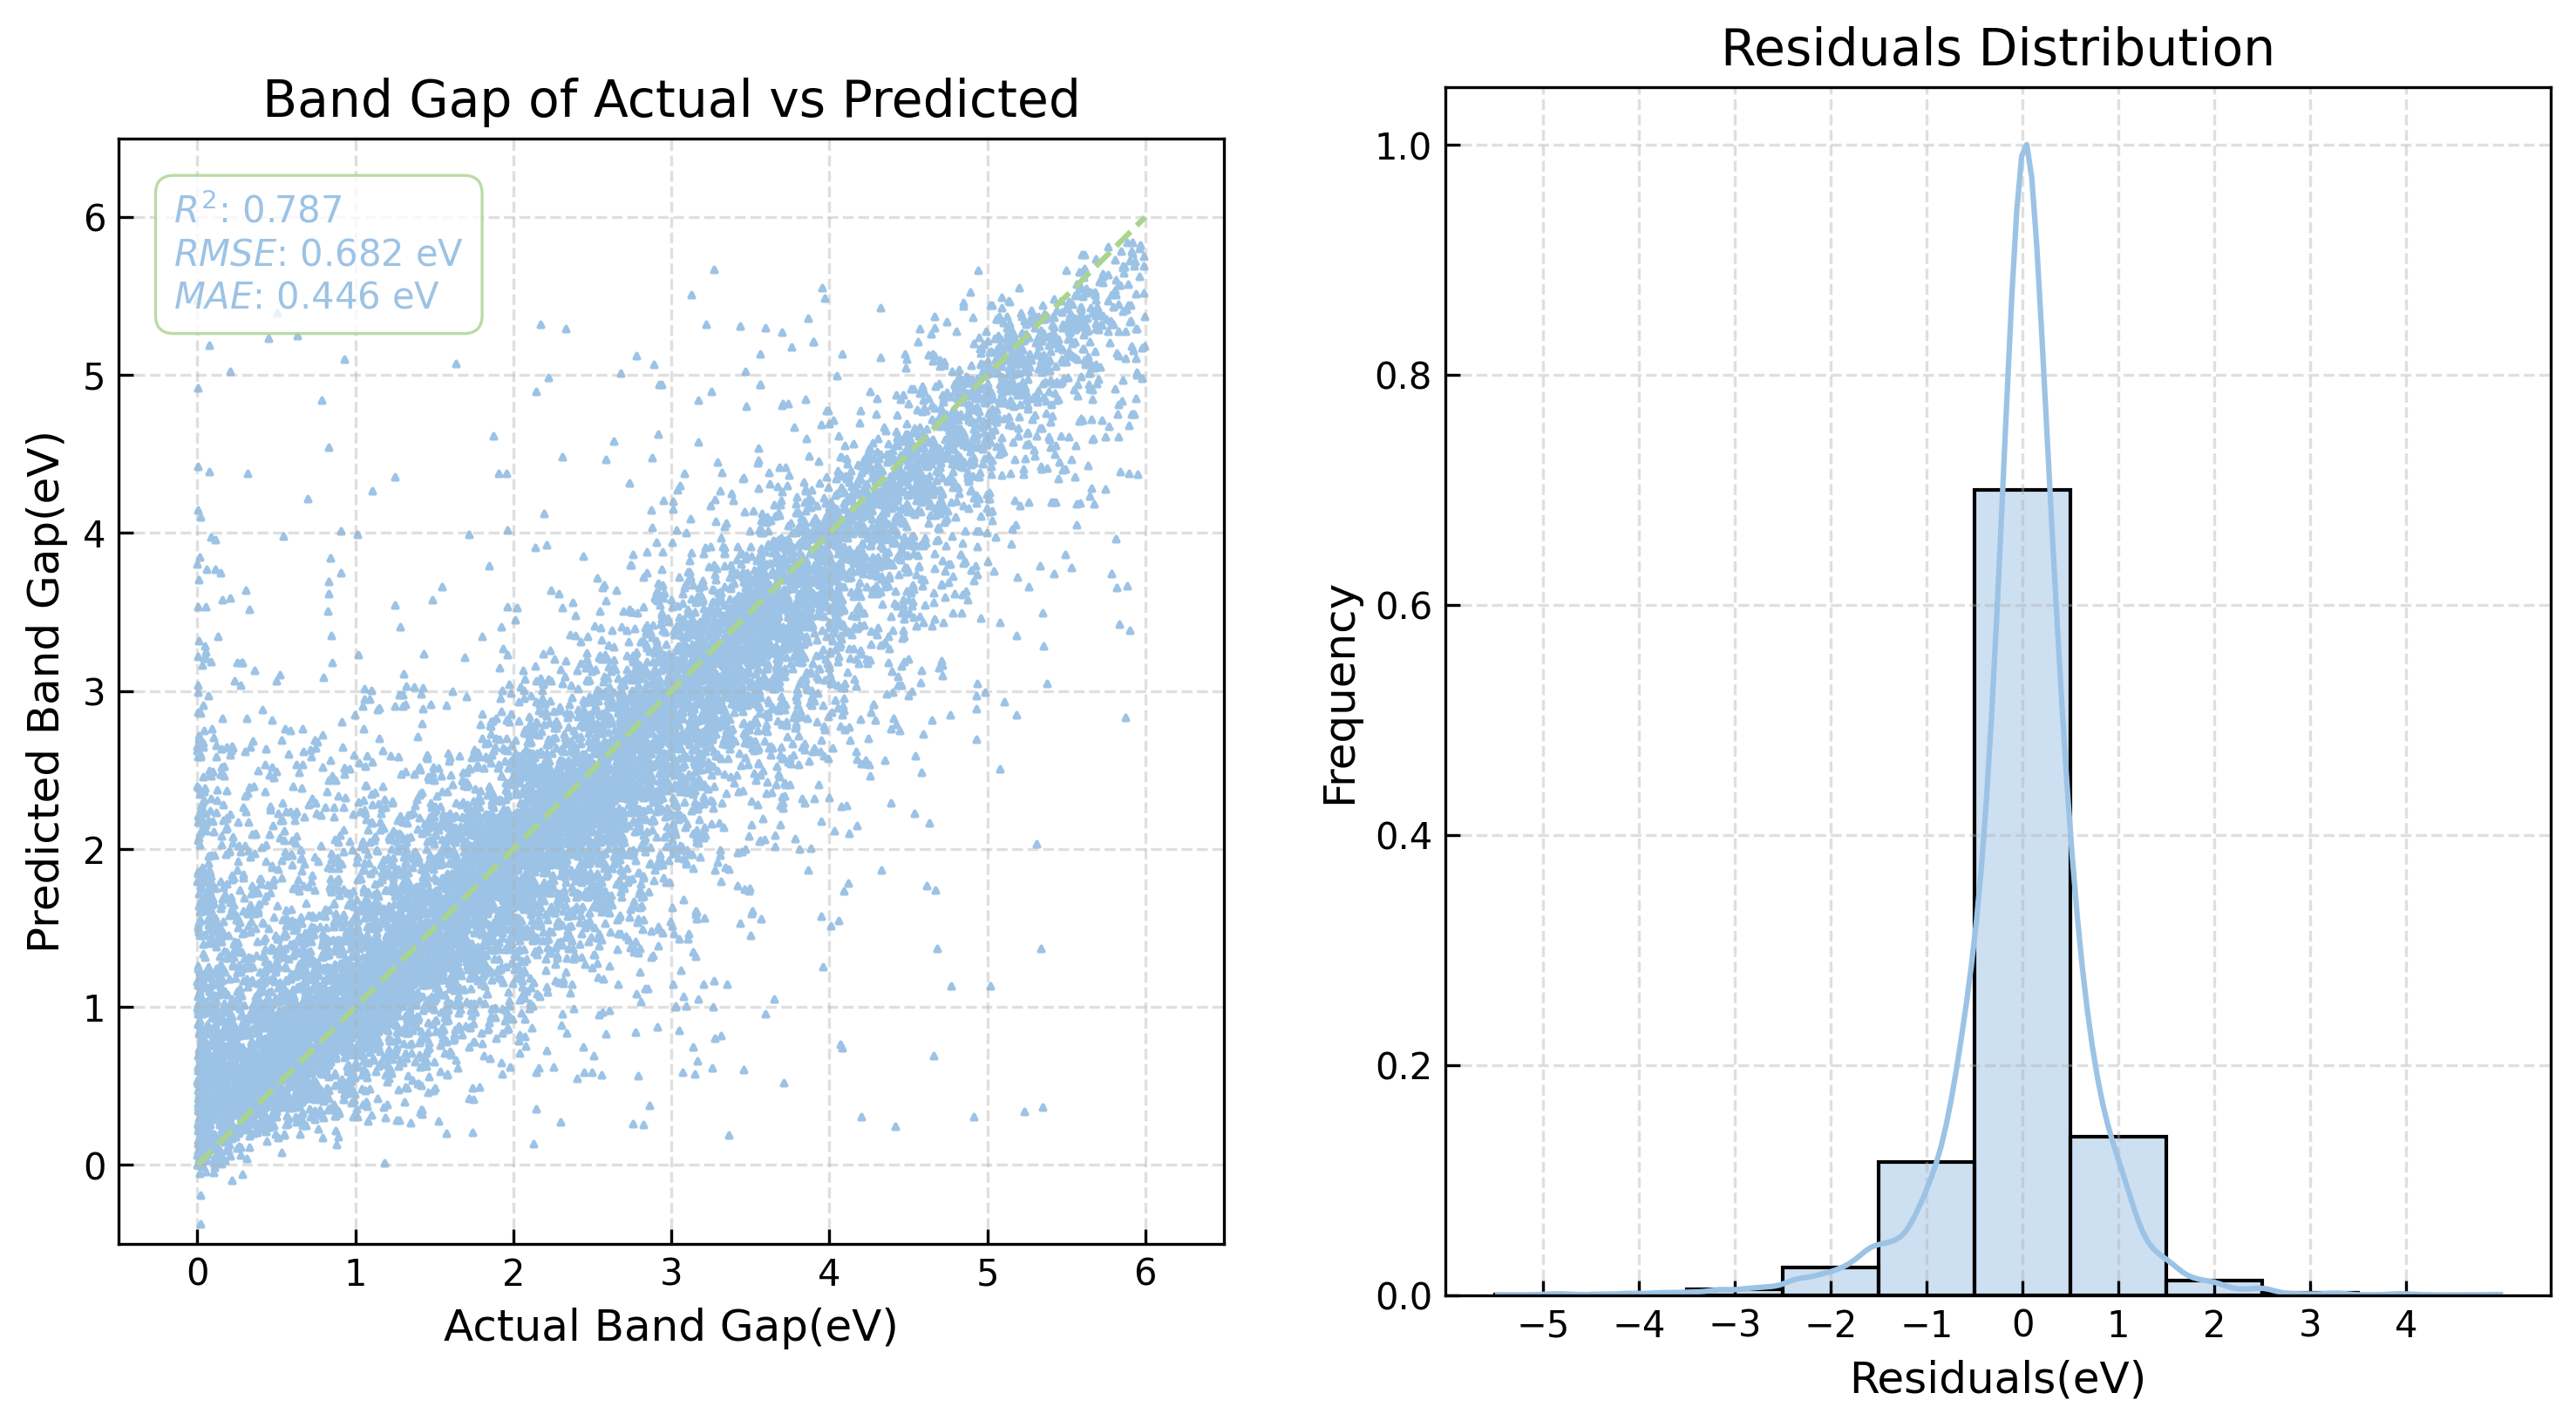


Model Evaluation Results:
Test set: R²: 0.7869 RMSE: 0.6823 MAE: 0.4459
[Test DFT -> EXP] Evaluating DFT GBR on EXP test set:


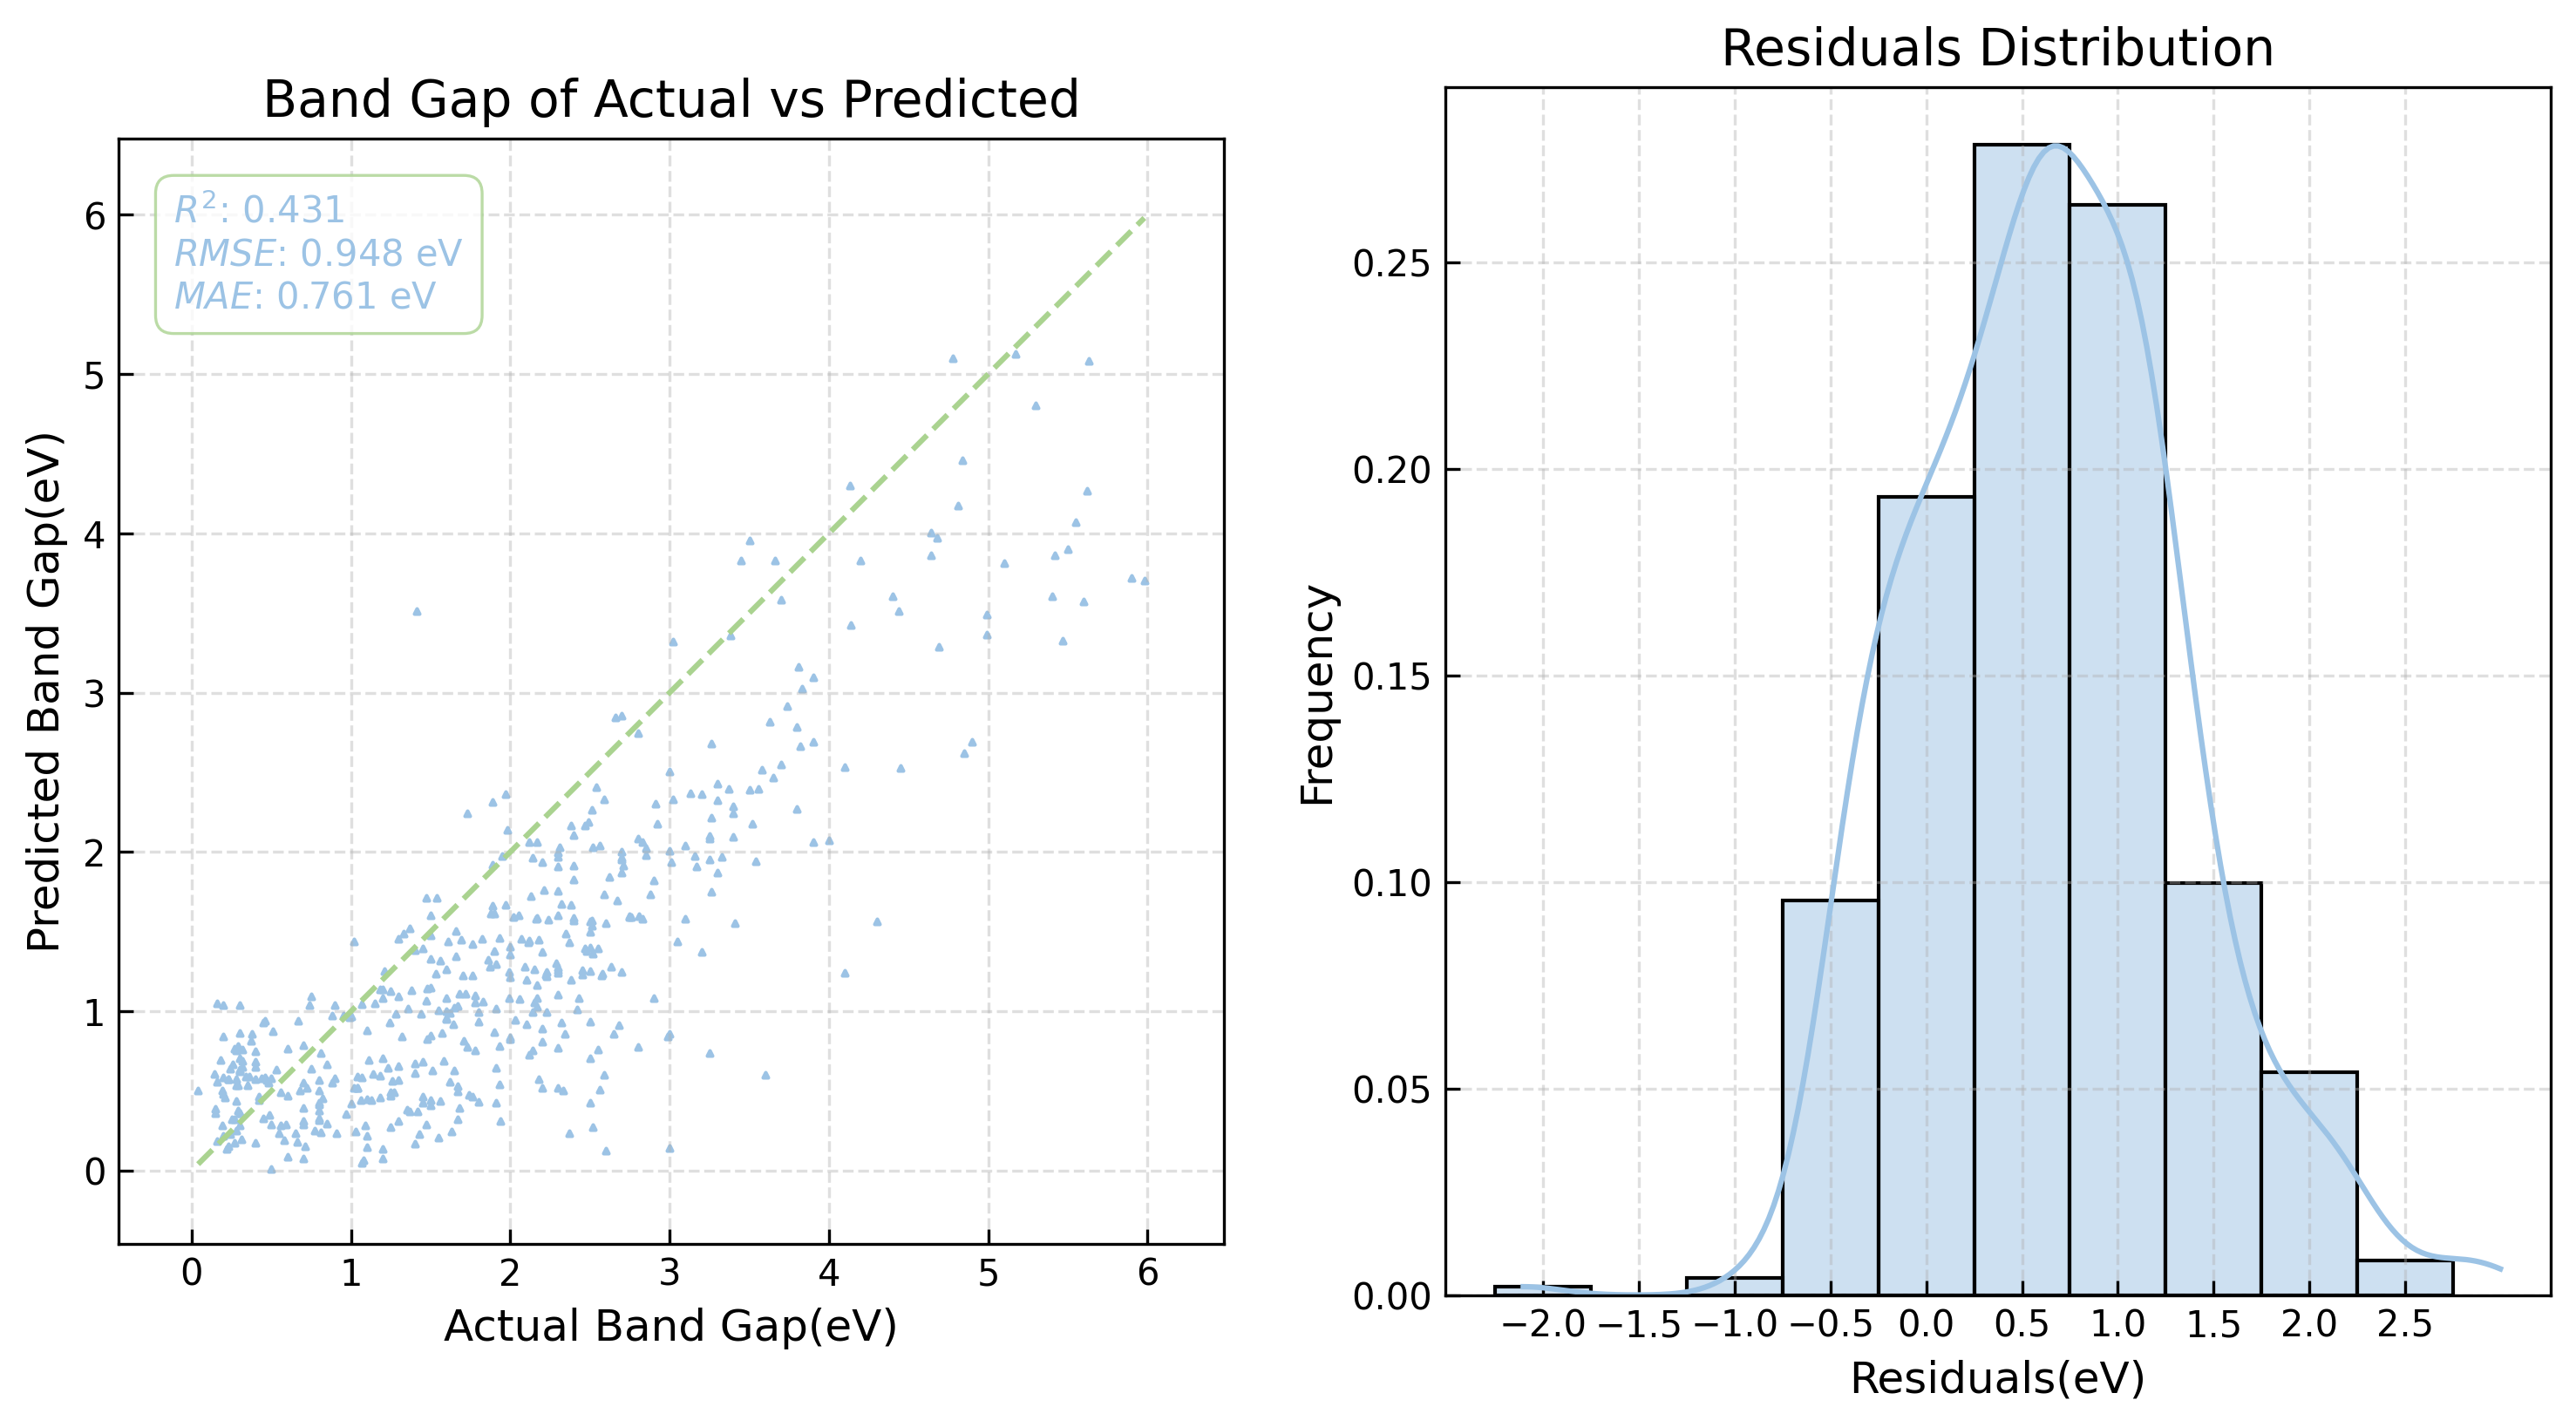


Model Evaluation Results:
Test set: R²: 0.4311 RMSE: 0.9479 MAE: 0.7613


In [9]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
gbr_best = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    max_features=0.25,
    random_state=RANDOM_SEED
)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(gbr_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [10]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,GBR,Train,dft,dft,0.957991,0.302656,0.206448
1,GBR,Test,dft,dft,0.786912,0.682326,0.445921
2,GBR,Test,dft,exp,0.431051,0.947898,0.761256


### EXP Model

In [11]:
# using random search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimization begin...")
# define the parameter distributions  for the KNN model
param_distributions = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 7, 10],
    'max_features': ['sqrt', 'log2', 0.25, 0.5, 1.0],
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED)
# create a randomized search CV object
# using n_iter=200 for a faster search, you can increase this for better results
# forget to assign metrics score, the default is R2 score
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_distributions,
                n_iter=200, cv=kf, verbose=2, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(exp_train_X, exp_train_y)


['EXP GBR'] HP optimization begin...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 7, 10],
                                        'max_features': ['sqrt', 'log2', 0.25,
                                                         0.5, 1.0],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [12]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_n_estimators', 'param_max_depth', 
                                 'param_learning_rate', 'param_max_features', 'train_rmse', 'test_rmse']]

# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'exp_random_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'n_estimators': 500, 'max_features': 0.25, 'max_depth': 5, 'learning_rate': 0.05}
Best Cross-Validation RMSE: 0.5652


,rank_test_score,param_n_estimators,param_max_depth,param_learning_rate,param_max_features,train_rmse,test_rmse
21,1,500,5,0.05,0.25,0.108755,0.565192
168,2,500,4,0.10,log2,0.142704,0.565551
115,3,500,5,0.05,0.5,0.102363,0.566325
180,4,500,7,0.10,log2,0.012611,0.567111
158,5,200,7,0.10,log2,0.043364,0.567517


### Overfitting check

####################################################################################################
[EXP - GBR] Training GBR on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.5s
Model training completed!
[Train_error] Evaluating EXP GBR on EXP train set:


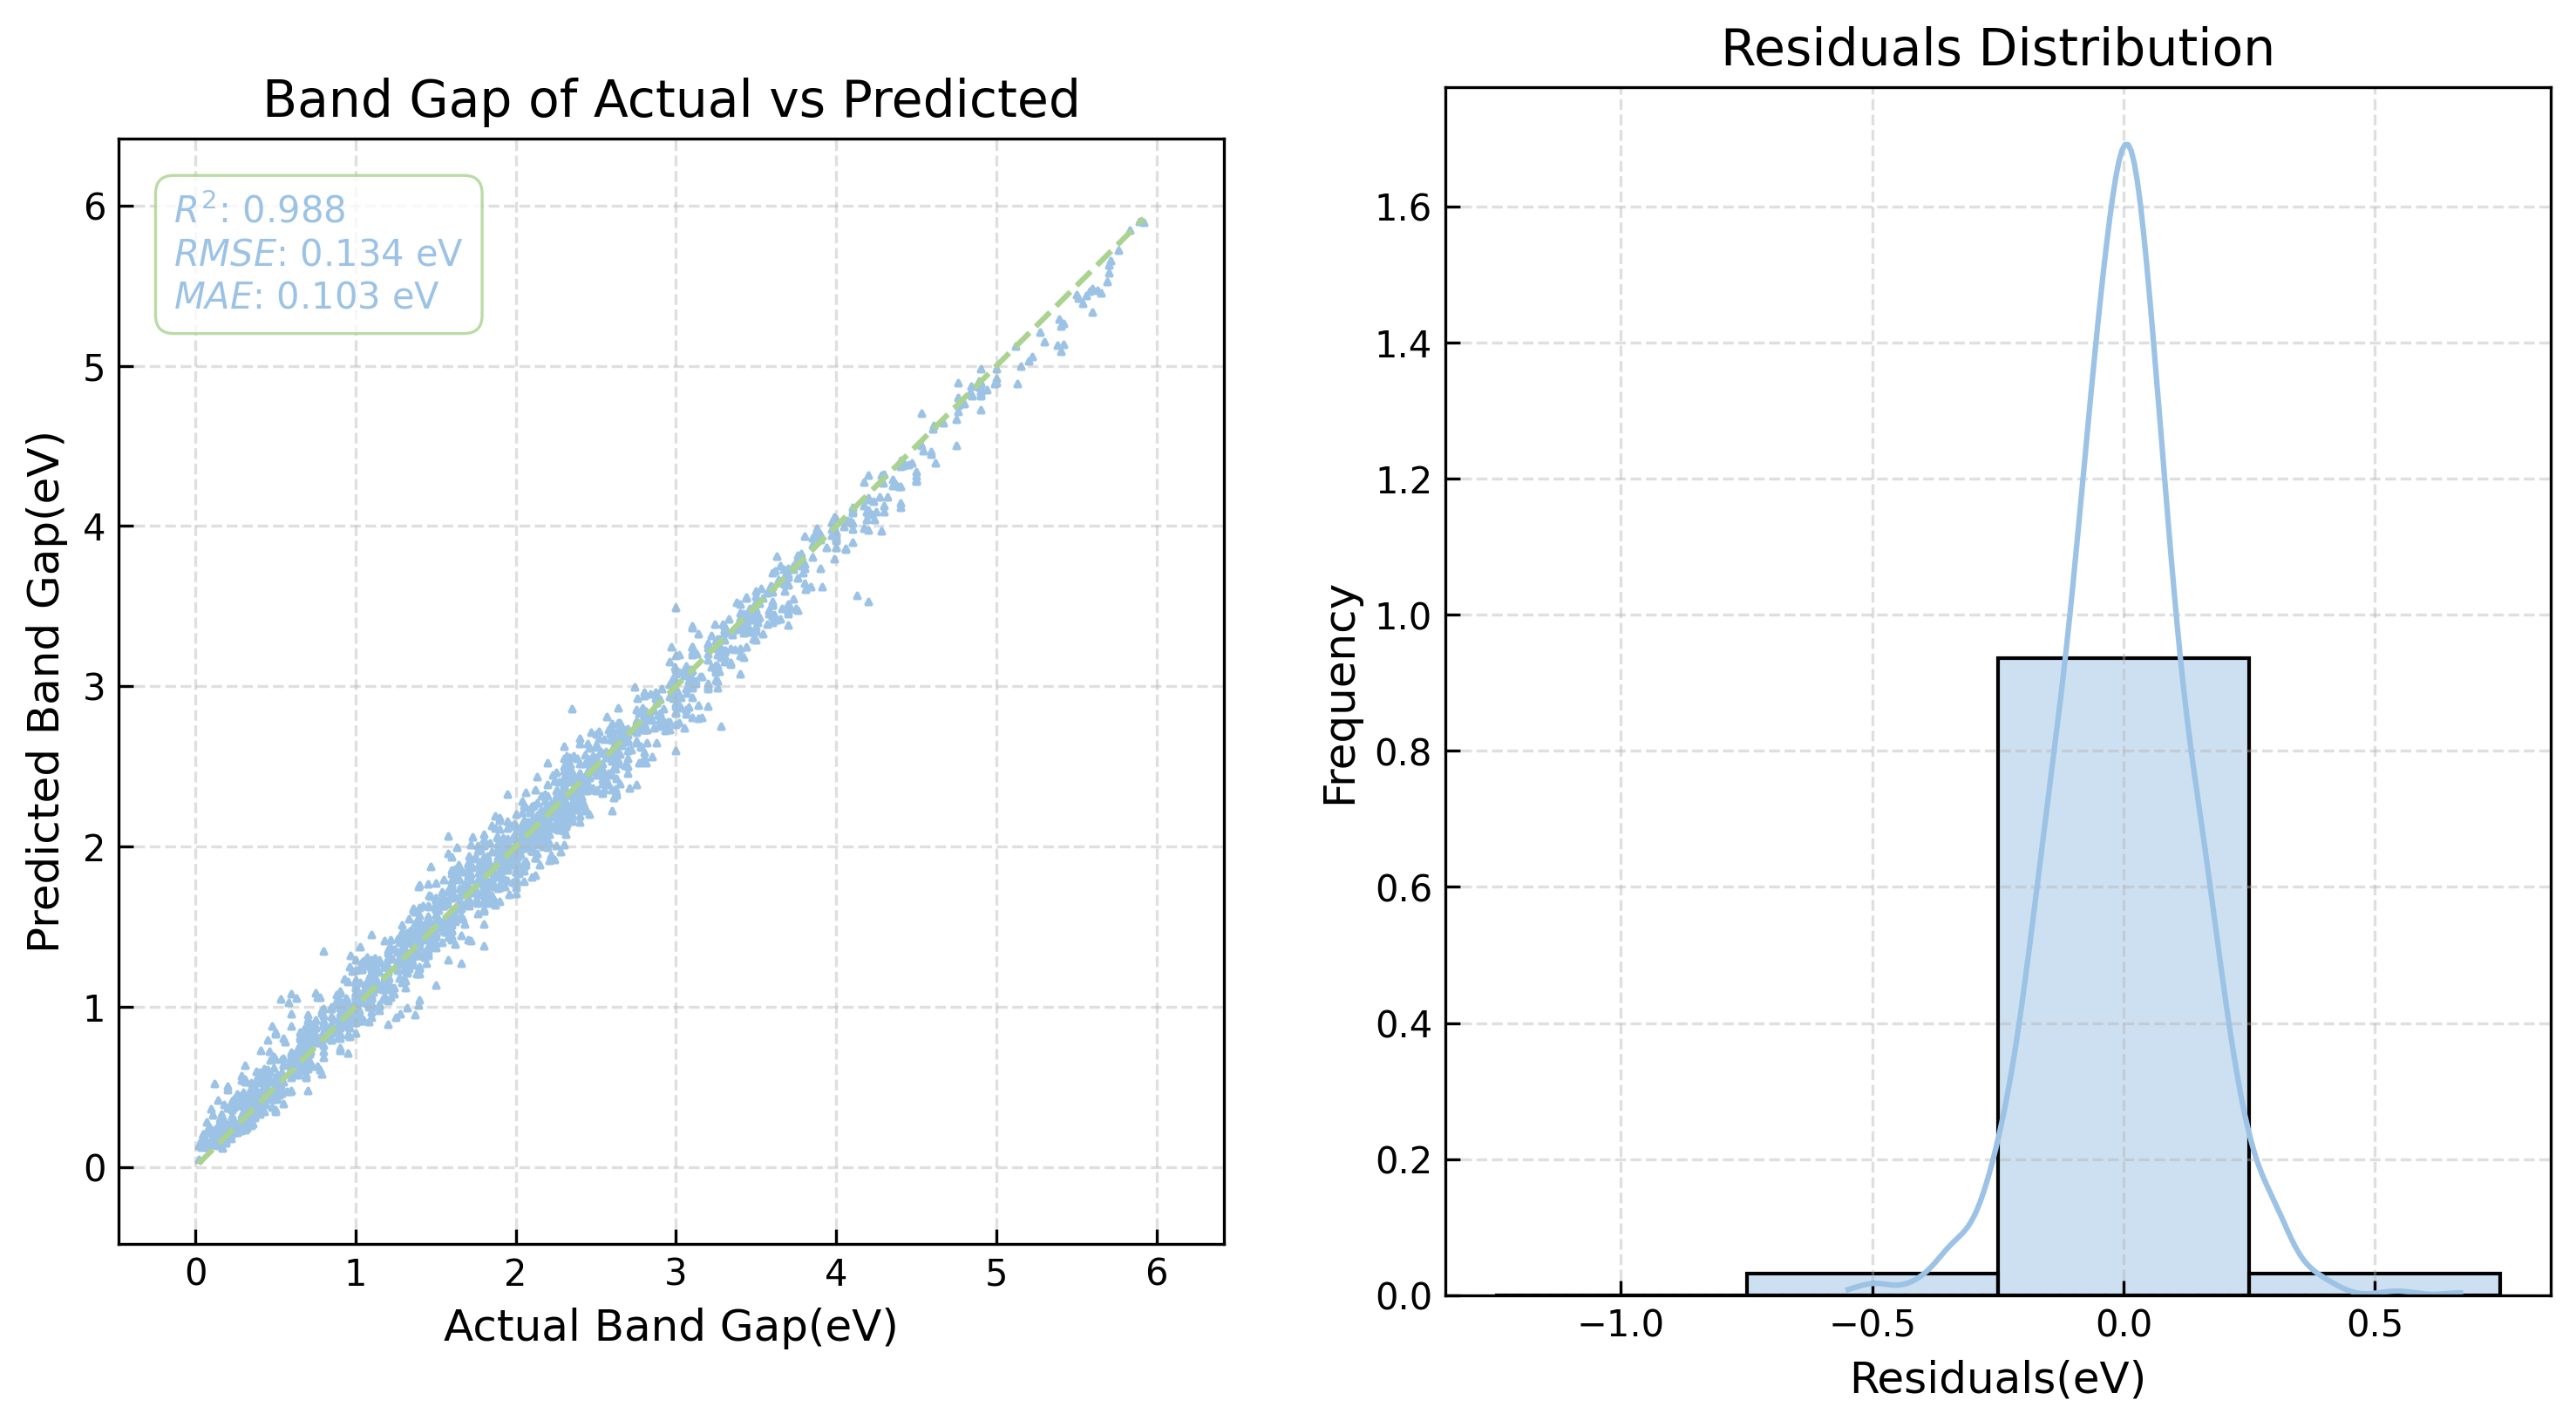


Model Evaluation Results:
Test set: R²: 0.9877 RMSE: 0.1344 MAE: 0.1025
[Test EXP -> EXP] Evaluating EXP GBR on EXP test set:


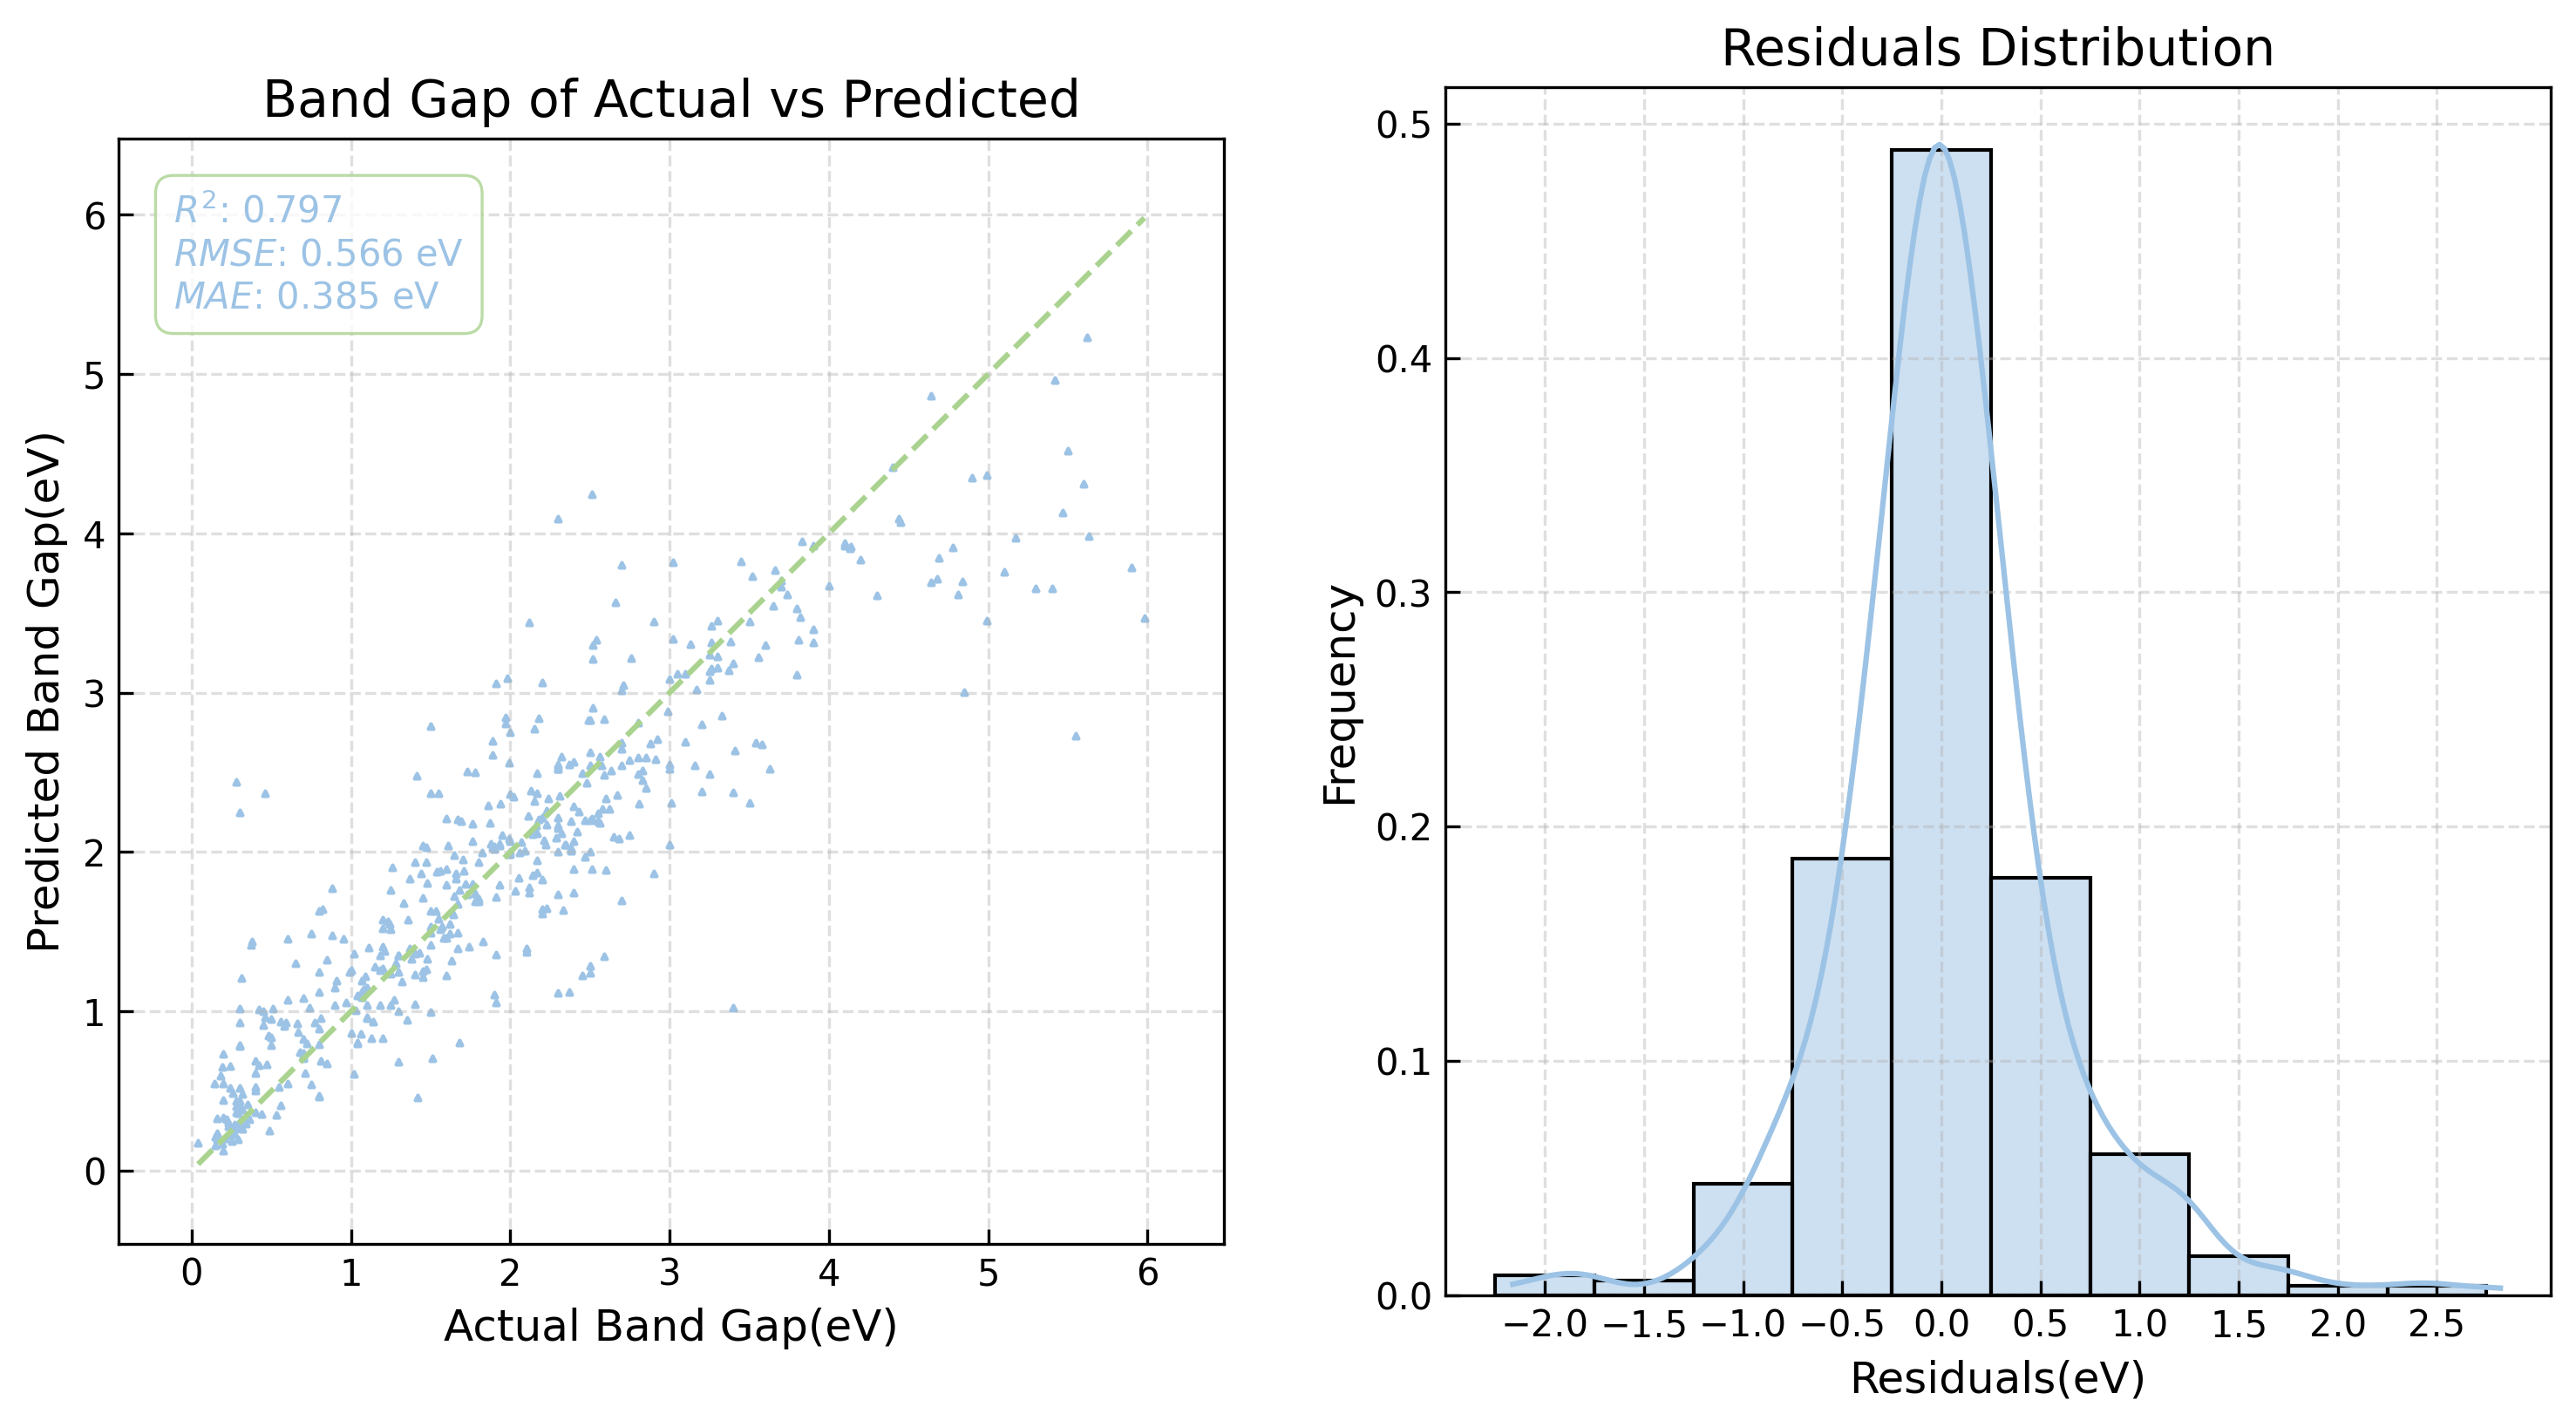


Model Evaluation Results:
Test set: R²: 0.7971 RMSE: 0.5661 MAE: 0.3851
[Test EXP -> DFT] Evaluating EXP GBR on DFT test set:


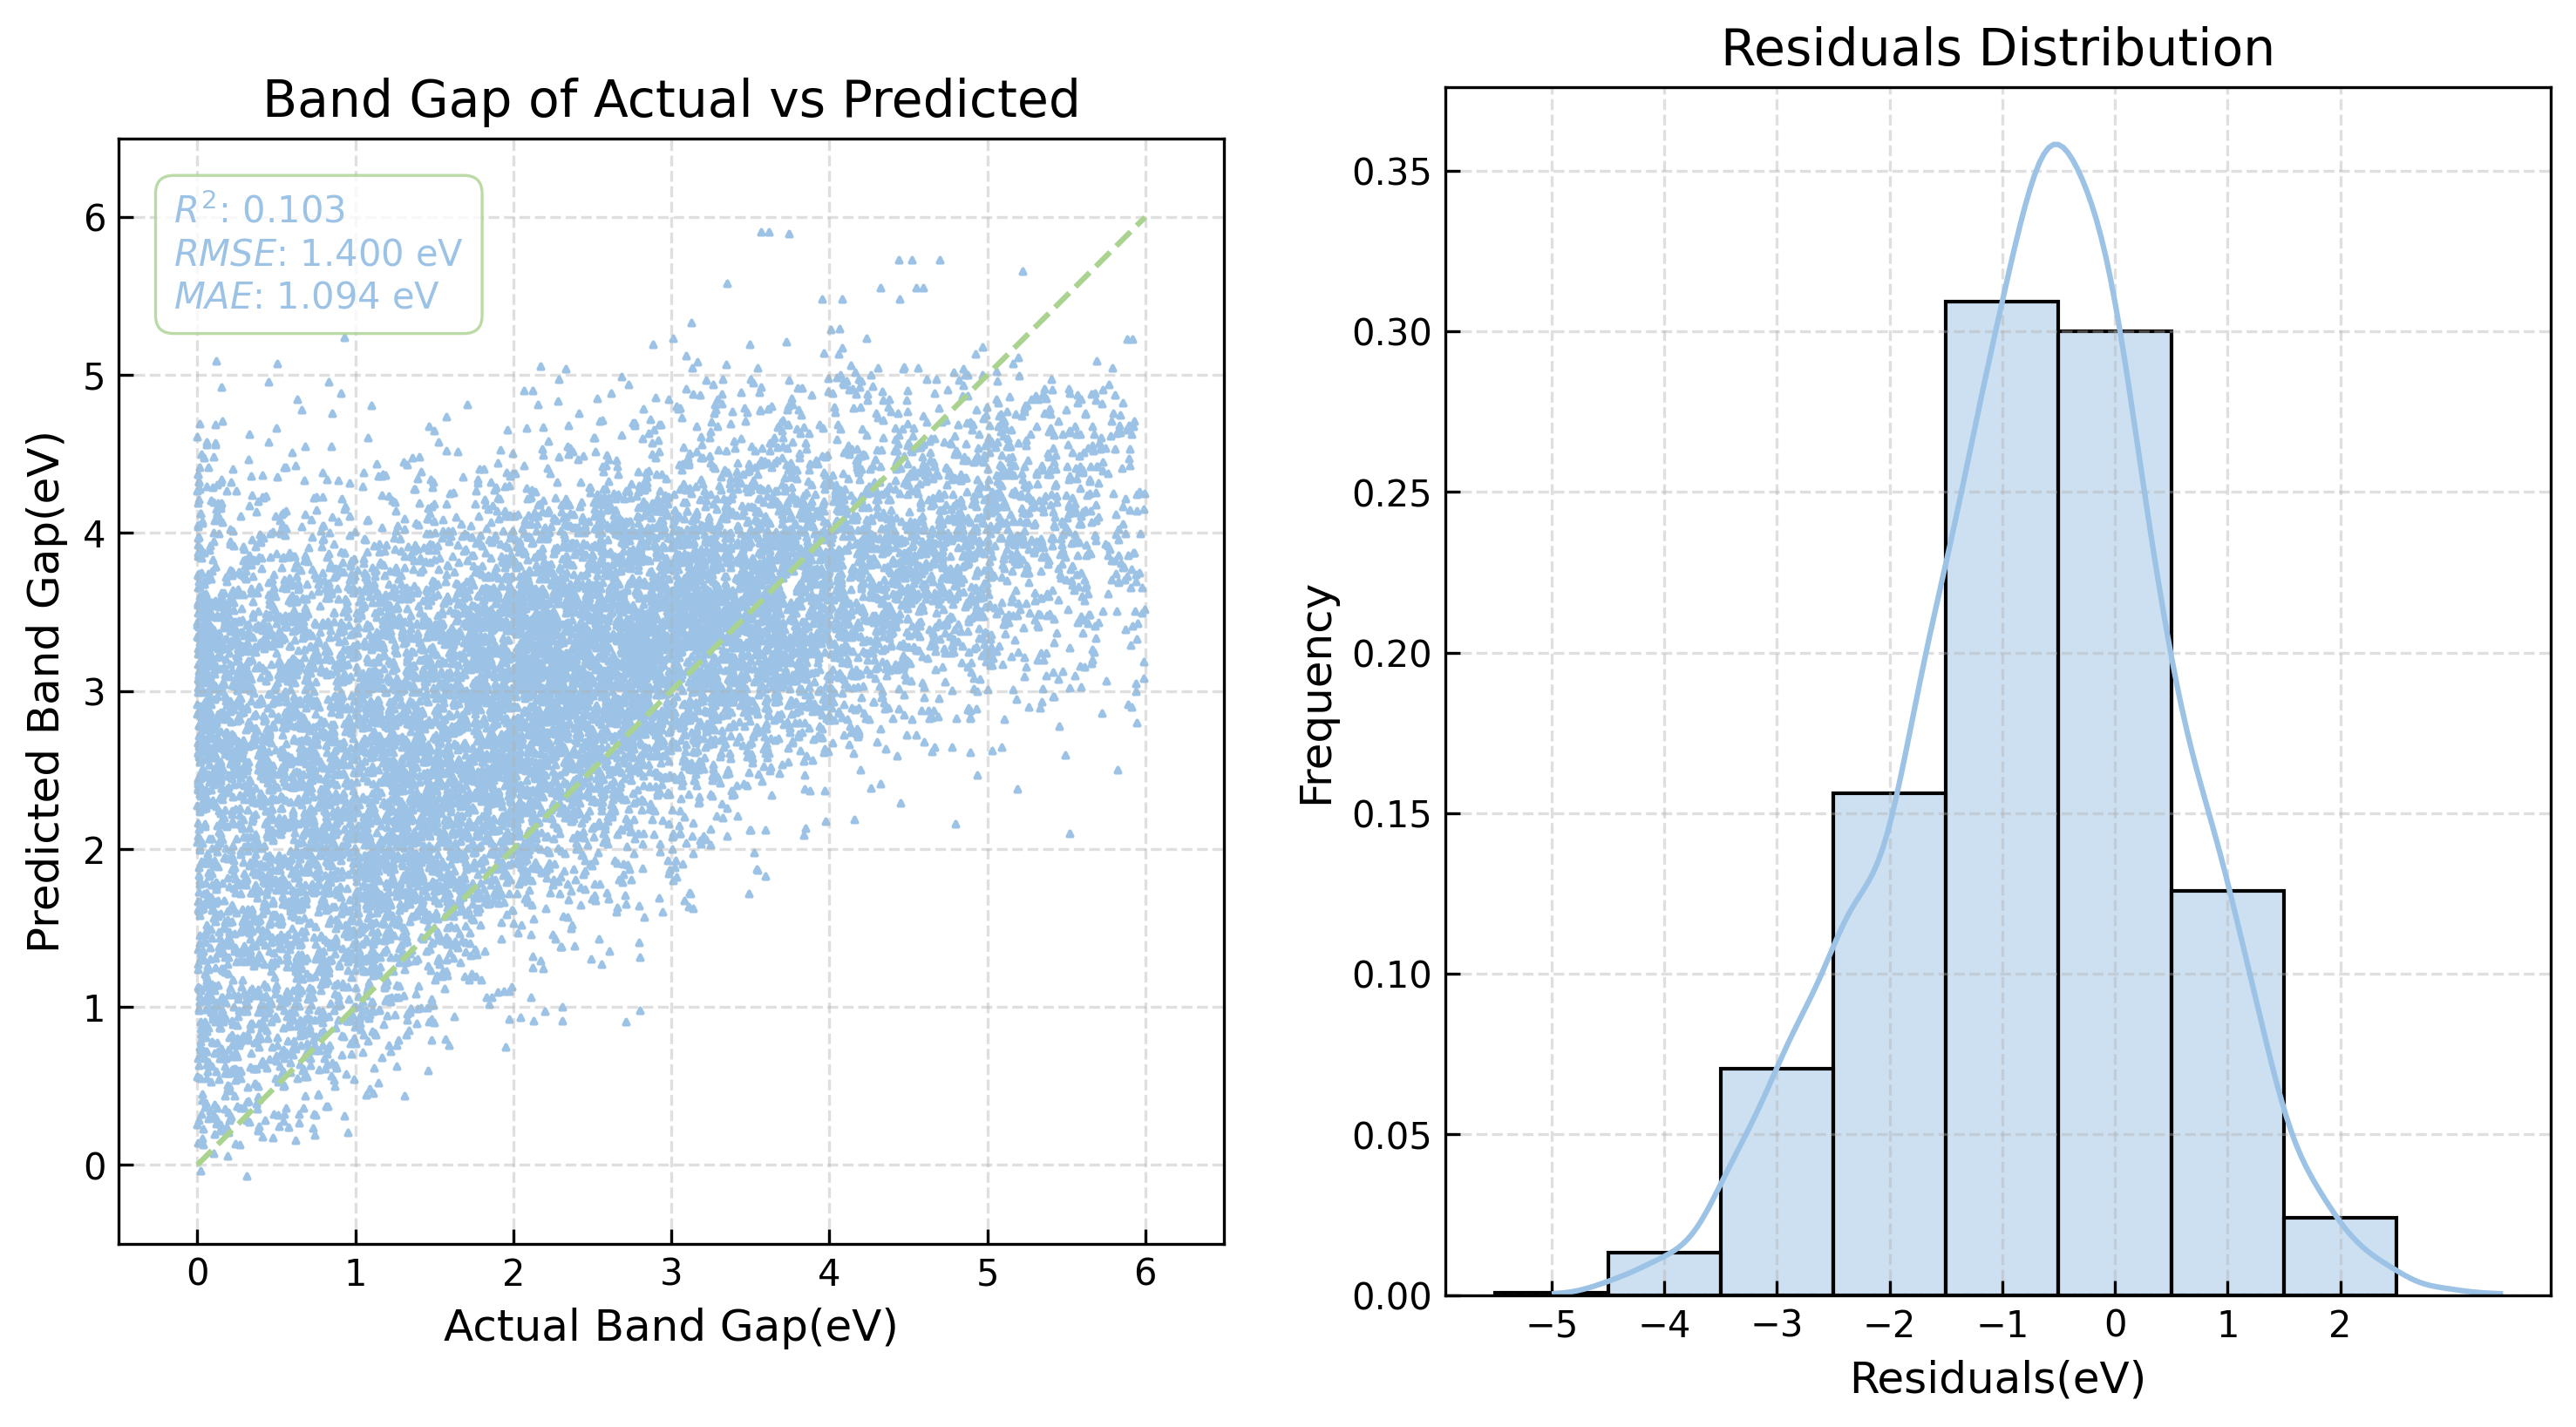


Model Evaluation Results:
Test set: R²: 0.1034 RMSE: 1.3996 MAE: 1.0940


In [13]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
gbr_best = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    max_features=0.25,
    random_state=RANDOM_SEED
)

# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(gbr_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [14]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,GBR,Train,exp,exp,0.987725,0.134431,0.102507
1,GBR,Test,exp,exp,0.797062,0.566118,0.385087
2,GBR,Test,exp,dft,0.103417,1.399613,1.093976
